# Predicting the Sentiment of Tweet Replies

## Installation

In [42]:
!pip install textblob

In [43]:
!pip install transformers tensorflow

## Data Preprocessing

In [44]:
import re
import pandas as pd
import nltk
import string
from plotly import graph_objects as go
import numpy as np

nltk.download("stopwords")
stopword_list = nltk.corpus.stopwords.words("english")


def read_file(filename):
    """
    Converts given text file into dataframe with cols of label and
    (positive, negative, neutral)
    """
    tweet_df = pd.read_csv(filename, sep="\t", lineterminator="\n")
    tweet_df.columns = ["label", "tweet"]
    return tweet_df


def clean_tweet(tweet):
    """
    tweet: string
    returns: cleaned tweet (string)
    """
    tweet = tweet.lower()
    # remove punctuation
    tweet = "".join([c for c in tweet if c not in string.punctuation])
    # remove stop words
    tweet = "".join([(c + " ") for c in tweet.split(" ") if c not in stopword_list])
    # remove all @mentions
    tweet = re.sub(r"(@.*?)[\s]", " ", tweet)
    # remove twitter URL at end of tweet (https://t.co/...)
    tweet = re.sub("http[s]?://\S+", "", tweet)
    return tweet


def visualize_tweets(tweet_df):
    """
    tweet_df: dataframe
    """
    index = ["negative", "neutral", "positive"]

    tweet_u, tweet_counts = np.unique(tweet_df["label"], return_counts=True)
    text = [round(x / len(tweet_df), 3) for x in tweet_counts]
    fig = go.Figure(
        data=[
            go.Bar(
                name="Tweets",
                x=index,
                y=tweet_counts / len(tweet_df),
                text=text,
            ),
        ],
        layout=go.Layout(
            title="Proportion of Tweets by Sentiment",
            yaxis_title="Proportion of Total Tweets",
        ),
    )
    fig.show()


def preprocess_tweets(filename):
    tweet_df = read_file(filename)
    tweet_df["tweet"] = tweet_df["tweet"].apply(clean_tweet)
    return tweet_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
import nltk
from textblob import TextBlob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

label_dict = {"negative": 0, "positive": 1, "neutral": 2}

def extract_features(filename):
    tweets_df = preprocess_tweets(filename)

    sid = SentimentIntensityAnalyzer()
    tweets_df["sentiment"] = tweets_df["tweet"].apply(
        lambda x: sid.polarity_scores(x).get("compound")
    )
    tweets_df["subjectivity"] = tweets_df["tweet"].apply(
        lambda x: TextBlob(x).sentiment.subjectivity
    )
    tweets_df["num_tokens"] = tweets_df["tweet"].apply(lambda x: len(x.split(" ")))
    tweets_df["label"] = tweets_df["label"].apply(lambda x : label_dict[x])

    return tweets_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [46]:
train_tweets_df = extract_features("final_tweets_training.txt")
test_tweets_df = extract_features("final_tweets_test.txt")

## Baseline Predictor

(0.34954098157596203, 0.35180613058836935)

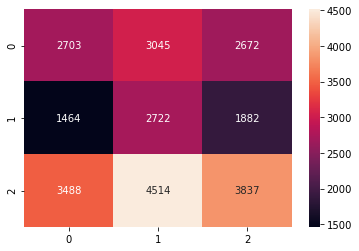

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns

def get_sentiment_label(x):
    if (x < -0.3):
        return 0
    if (x > 0.3):
        return 1
    else:
        return 2

def baseline_predictor():
    tweets_df = extract_features("final_tweets_training.txt")
    tweets_df["prediction"] = tweets_df["sentiment"].apply(get_sentiment_label)
    correct_prediction = tweets_df[tweets_df["prediction"] == tweets_df["label"]]
    accuracy = len(correct_prediction) / len(tweets_df)

    cm = confusion_matrix(tweets_df["label"], tweets_df["prediction"])
    f = sns.heatmap(cm, annot=True, fmt='d')

    f1 = f1_score(tweets_df["label"], tweets_df["prediction"], average="macro")
    
    return f1, accuracy

baseline_predictor()

In [68]:
from sklearn.metrics import accuracy_score

def train_rf_model():
    train_features_df = train_tweets_df.drop(["label", "tweet"], axis=1)
    test_features_df = test_tweets_df.drop(["label", "tweet"], axis=1)
    train_features, train_labels = train_features_df, train_tweets_df["label"]
    test_features, test_labels = test_features_df, test_tweets_df["label"]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(train_features, train_labels)

    y_pred = rf.predict(test_features)
    accuracy = accuracy_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred, average="macro")
    print('Accuracy:', round(accuracy, 3), '%.')
    print('F1:', round(f1, 3), '%.')

train_rf_model()

Accuracy: 0.391 %.
F1: 0.378 %.


## TextCNN Model

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#this takes about 10 minutes to run
!wget -nc https://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!ls -lat

glove_file = "glove.840B.300d.txt"

def get_glove_mapping(file):
    """
    Gets the mapping of words from the vocabulary to pretrained embeddings
    
    INPUT:
    vocab       - set of vocabulary words
    file        - file with pretrained embeddings

    OUTPUT:
    glove_map   - mapping of words in the vocabulary to the pretrained embedding
    
    """
    glove_map = {}
    with open(file,'rb') as fi:
        for l in fi:
            try:
                tokens = l.decode("utf-8").split(" ")
                word = str(tokens[0]).lower()
                arr = [float(x) for x in tokens[1:]]
                glove_map[word] = np.array(arr)
            except:
                #some lines have urls, we don't need them.
                pass
    return glove_map

def get_embeddings(vocab, glove_map):
    n_embed = len(vocab)
    d_embed = 300
    weights_matrix = np.zeros((n_embed + 1, d_embed))
    for word, i in vocab.items():
    if word in glove_map:
        weights_matrix[i] = glove_map[word]
    return weights_matrix

glove_map = get_glove_mapping(glove_file)
embeddings = get_embeddings(tokenizer.word_index, glove_map)

In [59]:
import bz2
import _pickle as cPickle

embeddings = cPickle.load(bz2.BZ2File('embedding_weights.pbz2','rb'))

In [69]:
from sklearn import model_selection
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

params = {'num_words': 250, 
          'embedding_size': 300, 
          'epochs': 8, 
          'batch_size': 32, 
          'learning_rate': 0.001}

x_train, x_test, y_train, y_test = model_selection.train_test_split(test_tweets_df['tweet'], test_tweets_df['label'], test_size=0.26, shuffle=True)

tokenizer = Tokenizer(num_words=params['num_words'])
tokenizer.fit_on_texts(list(x_train))
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=params['num_words'])
x_test= pad_sequences(x_test, maxlen=params['num_words'])

In [128]:
from keras.models import Sequential
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.metrics import Precision, Recall

import tensorflow as tf


input_dim = x_train.shape[1]

model = Sequential()
model.add(layers.Embedding(embeddings.shape[0], params['embedding_size'], input_length=params['num_words']))
model.add(Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu', kernel_regularizer='l2'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu', kernel_regularizer='l2'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(3, activation='sigmoid'))
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 250, 300)          16568400  
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 250, 256)          307456    
_________________________________________________________________
max_pooling1d_130 (MaxPoolin (None, 125, 256)          0         
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 125, 128)          131200    
_________________________________________________________________
max_pooling1d_131 (MaxPoolin (None, 62, 128)           0         
_________________________________________________________________
conv1d_132 (Conv1D)          (None, 62, 64)            32832     
_________________________________________________________________
max_pooling1d_132 (MaxPoolin (None, 31, 64)          

In [129]:
from sklearn.utils import compute_class_weight

history = model.fit(x_train, y_train, epochs=4,verbose=True,validation_data=(x_test, y_test), batch_size=16)

Epoch 1/4
60/60 [==============================] - 14s 225ms/step - loss: 1.7475 - accuracy: 0.3697 - val_loss: 1.3510 - val_accuracy: 0.3940
Epoch 2/4
60/60 [==============================] - 13s 222ms/step - loss: 1.2201 - accuracy: 0.3897 - val_loss: 1.0763 - val_accuracy: 0.3940
Epoch 3/4
60/60 [==============================] - 13s 225ms/step - loss: 1.0533 - accuracy: 0.5284 - val_loss: 1.0292 - val_accuracy: 0.5134
Epoch 4/4
60/60 [==============================] - 13s 224ms/step - loss: 0.9602 - accuracy: 0.5788 - val_loss: 0.9970 - val_accuracy: 0.5433
